In [16]:
import pandas as pd
import numpy as np
import sklearn.linear_model as linear
import sklearn.preprocessing as pre
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [2]:
!head adult.data

39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K
38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, <=50K
53, Private, 234721, 11th, 7, Married-civ-spouse, Handlers-cleaners, Husband, Black, Male, 0, 0, 40, United-States, <=50K
28, Private, 338409, Bachelors, 13, Married-civ-spouse, Prof-specialty, Wife, Black, Female, 0, 0, 40, Cuba, <=50K
37, Private, 284582, Masters, 14, Married-civ-spouse, Exec-managerial, Wife, White, Female, 0, 0, 40, United-States, <=50K
49, Private, 160187, 9th, 5, Married-spouse-absent, Other-service, Not-in-family, Black, Female, 0, 0, 16, Jamaica, <=50K
52, Self-emp-not-inc, 209642, HS-grad, 9, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 45, United-States, >50K
31, 

In [3]:
!tail -n 14 adult.names

age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
education-num: continuous.
marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Ri

# Data loading & preprocessing

In [2]:
# parse feature column names from 'adult.names' file

with open('adult.names') as file:
    rows = file.read().split('\n')[-15:]
    col_names = [row.split(':')[0] for row in rows][:-1] + ['label']

In [6]:
# read training and test data

df = pd.read_csv('adult.data', header=None, names=col_names, skipinitialspace=True)
test_df = pd.read_csv('adult.test', header=None, names=col_names, skipinitialspace=True)
all_data = pd.concat([df, test_df])
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [11]:
# process training data to labels and features

y = df['label'] == '>50K'
protected_label = df['sex'] == 'Female'

x = df.drop(columns=['label', 'fnlwgt', 'sex', 'native-country', 'marital-status'])

# separate by dtype, so that we can one-hot endoce categorical variables
x_categorical = x.select_dtypes('object')
x_numerical = x.select_dtypes('int')

# one-hot encodind
enc = pre.OneHotEncoder(sparse=False)
x_one_hot = enc.fit_transform(x_categorical)

# create sensible column names for the one-hot encoded variables
cols = []
for main_category, sub_categories in zip(x_categorical.columns, enc.categories_):
    cols += [f'{main_category}_{sub}' for sub in sub_categories]

x_enc = pd.DataFrame(data=x_one_hot, columns=cols)
x_post = pd.concat([x_numerical, x_enc], axis=1)

In [9]:
x_categorical.head()

,workclass,education,occupation,relationship,race
0,State-gov,Bachelors,Adm-clerical,Not-in-family,White
1,Self-emp-not-inc,Bachelors,Exec-managerial,Husband,White
2,Private,HS-grad,Handlers-cleaners,Not-in-family,White
3,Private,11th,Handlers-cleaners,Husband,Black
4,Private,Bachelors,Prof-specialty,Wife,Black


In [10]:
x_numerical.head()

,age,education-num,capital-gain,capital-loss,hours-per-week
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40
3,53,7,0,0,40
4,28,13,0,0,40


In [14]:
x_post.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,13,2174,0,40,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,50,13,0,0,13,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,38,9,0,0,40,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,53,7,0,0,40,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28,13,0,0,40,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [13]:
cols[5:15]

['workclass_Self-emp-inc',
 'workclass_Self-emp-not-inc',
 'workclass_State-gov',
 'workclass_Without-pay',
 'education_10th',
 'education_11th',
 'education_12th',
 'education_1st-4th',
 'education_5th-6th',
 'education_7th-8th']

# Fitting a logistic regression model

In [22]:
model = linear.LogisticRegression(penalty='none', max_iter=2000)
model.fit(x_post, y)

probs = model.predict_proba(x_post)[:, 1]  # probability of y = 1

print(f'Base model score: {model.score(x_post, y)}')
print(f'Base model score for females: {model.score(x_post[protected_label], y[protected_label])}')
print(f'Base model score for males: {model.score(x_post[~protected_label], y[~protected_label])}')

Base model score: 0.8515094745247381
Base model score for females: 0.9267477485841612
Base model score for males: 0.8143184947223497


In [18]:
# 0.5 is used as threshold
((probs >= 0.5) == y).mean()

0.8515094745247381

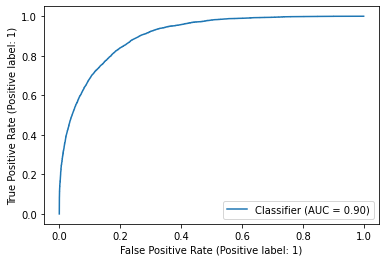

In [26]:
# fpr, tpr, thresholds = metrics.roc_curve(y, probs)
# metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

metrics.RocCurveDisplay.from_predictions(y, probs)

/var/folders/nc/dhtws2m1317bwzbsxq9n3_gc0000gn/T/ipykernel_48096/2849763122.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


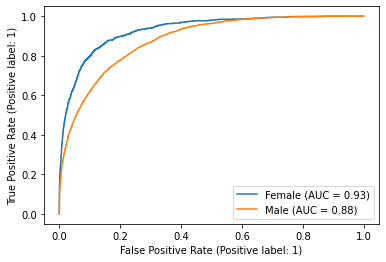

In [27]:
fig, ax = plt.subplots()

metrics.RocCurveDisplay.from_predictions(y[protected_label], probs[protected_label], ax=ax, name='Female')
metrics.RocCurveDisplay.from_predictions(y[~protected_label], probs[~protected_label], ax=ax, name='Male')
fig.show()

# Deriving equal demographic predictor

In [29]:
# rate = pos predictions rate within class
# converts selected rate to thresholds for each protected class
def rate_to_th(rate: float, probs: np.ndarray):
    return np.sort(probs)[max(int((1 - rate) * probs.shape[0]) - 1, 0)]

In [30]:
# calculate th curves by rate

male_probs = probs[~protected_label]
female_probs = probs[protected_label]
y_m = y[~protected_label]
y_f = y[protected_label]

rates = np.linspace(0, 1, 100)

th_m = list(map(lambda r: rate_to_th(r, male_probs), rates))
th_f = list(map(lambda r: rate_to_th(r, female_probs), rates))

Text(0.5, 0, 'class threshold')

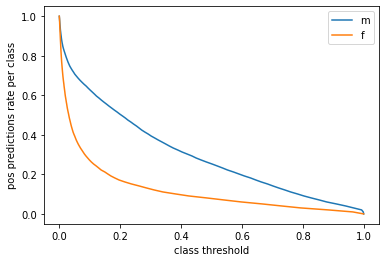

In [32]:
fig, ax = plt.subplots()

ax.plot(th_m, rates, label='m')
ax.plot(th_f, rates, label='f')
ax.legend()

ax.set_ylabel('pos predictions rate per class')
ax.set_xlabel('class threshold')

In [34]:
# prediction correctness array
def th_to_profit(th: float, probs: np.ndarray, y: np.ndarray):
    yhat = (probs > th) * 1
    return (yhat == y)

In [35]:
# make predictions and calculate score for each rate -> threshold pair
p = [
    pd.concat([
        th_to_profit(thm, male_probs, y_m),
        th_to_profit(thf, female_probs, y_f)]
    ).mean()
    for (thm, thf) in zip(th_m, th_f)]

Text(0, 0.5, 'Score')

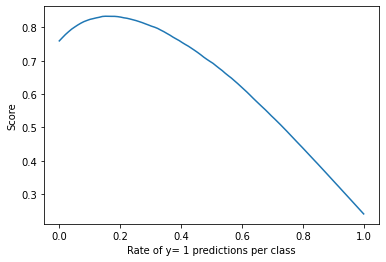

In [36]:
fig, ax = plt.subplots()
ax.plot(rates, p)
ax.set_xlabel('Rate of y= 1 predictions per class')
ax.set_ylabel('Score')

In [49]:
np.array(p).argmax()

15

In [50]:
th_f[15]

0.23720545100145635

In [51]:
th_m[15]

0.6842246335895886

In [52]:
max(p)

0.833082522035564

In [53]:
(male_probs >= th_m[15]).mean()

0.1515832950894906

In [54]:
(female_probs >= th_f[15]).mean()

0.15161080679602637

In [55]:
y.mean()

0.2408095574460244

In [56]:
(probs[:, 1] >= 0.5).mean()

0.19538711956021007

In [66]:
ths = np.linspace(0, 1, 10001)

In [67]:


pm = [th_to_profit(t, male_probs, y_m).mean() for t in ths]
pf = [th_to_profit(t, female_probs, y_f).mean() for t in ths]

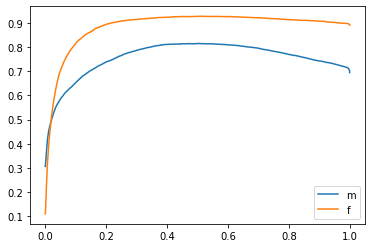

In [68]:
fig, ax = plt.subplots()

ax.plot(ths, pm, label='m')
ax.plot(ths, pf, label='f')
ax.legend()

In [69]:
np.array(pm).argmax()

5029

In [70]:
np.array(pf).argmax()

5175

In [71]:
ths[5029]

0.5029

In [72]:
ths[5175]

0.5175000000000001

In [73]:
pd.concat([
        th_to_profit(ths[5029], male_probs, y_m),
        th_to_profit(ths[5175], female_probs, y_f)]
    ).mean()

0.8519394367494856